In [1]:
import cv2
import time
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from IPython.display import clear_output

%run C:\nao_cv\geometrical\math_calibration.ipynb

arr = np.array

path = r'C:\nao_cv\geometrical\chessboard_images\\'

os.chdir(path)

size  = 38
shape = (7, 7)

files  = [f for f in listdir(path) if isfile(join(path, f))][::1]
photos = [x for x in files if (x[-4:] == '.jpg')]
strs   = [''.join([' ' if y == '_' else y for y in x]) for x in photos]
nums   = [[int(s) for s in x.split() if s.isdigit()][0] for x in strs]

frames = arr([dict(zip(['name', 'shift'], x)) for x in arr([files, nums]).T])
frames = arr(sorted(frames, key = lambda k: float(k['shift'])))


image_shape = cv2.imread(files[0]).shape

In [2]:
def text_data(frame, data):
    text = ''
    text += 'name:\n'
    text += '  %s\n' % (frame['name'])
    
    
    text += 'dist:  %s\n' % np.str(frame['shift'])
            
        
    text += 'calc:\n'
    if (data == None):
        text += '  None\n'
    else:
        for i in range(len(data)):
            for key in data[i]:
                if (key not in ['opt_len', 'corners']):
                    text += '  %s:  %s\n' % (key, np.str(data[i][key]))
            
    text += '\n'
    return text

In [3]:
def mean_of_points (points):
    return np.average(points.reshape(len(points)//3, 3, 2), axis=0)

In [4]:
def take_series (series_number):
    n = 10
    start = series_number * n
    points = np.zeros([3*n, 2])
    lens   = np.zeros([n, 3])

    for i in range(n):
        frame = frames[start+i]
        image = cv2.imread (frame['name'])
        data  = calibration_data (image, shape, size)

        points[3*i: 3*(i+1)] = data[0]['corners'][:,:2]
        lens  [i]            = data[0]['lens   ']
        

    aver_points = mean_of_points (points)
    aver_lens   = np.average (lens, axis=0)
    f, L = calibration_pix (size, aver_points, image_shape)
    incline = 180/pi*acos (np.sqrt (f[0][0]**2 + f[0][1]**2)/norm(f[0]))
    
    series = {}
    
    series['name']        = frame['name']
    series['points']      = points
    series['lenses']      = lens
    series['aver_points'] = aver_points
    series['aver_lenses'] = aver_lens
    series['lens_aver']   = L[0]
    series['shift']       = np.int(frame['shift'])
    series['incline']     = incline
    series['f_aver']      = f
    series['opt_len']     = norm(f)
    
    return series

In [5]:
set  = []
for i in range(len(frames)//10):
    series = take_series (i)
    set += [series]

In [6]:
def plot_data (y, x=None, markersize=None, fontsize=None, title=None, xlabel=None, ylabel=None, loc=1, legend=1):
    
    if (type(x) == type(None)):
        x = range(len(y))
        
    mean = np.average (y) * np.ones(len(y))
    std  = np.std (y)     * np.ones(len(y))
    mean_up   = mean + std
    mean_down = mean - std

    alpha = 0.2
    
    plt.plot (x, y,    'o', markersize=markersize, label='data')
    plt.plot (x, mean,      linestyle='--', label='mean = %.5s\nstd = %.5s' % ((mean[0]), std[0]))
    plt.plot (x, mean_up,   linestyle='--', label='mean + std', alpha=alpha)
    plt.plot (x, mean_down, linestyle='--', label='mean - std', alpha=alpha)

    if (fontsize != None):
        plt.title (title,  fontsize=fontsize+2)
    else:
        plt.title (title)
        
    plt.xlabel (xlabel, fontsize=fontsize)
    plt.ylabel (ylabel, fontsize=fontsize)
    if (legend == 1):
        plt.legend (loc = loc)

In [7]:
def plot_points (series_number):
    points = set[series_number]['points']
    lens   = set[series_number]['lenses']
    L      = set[series_number]['lens_aver']
    
    n = 10
    x = range(n)
    Lx = L[0] * np.ones(n)
    Ly = L[1] * np.ones(n)
    Lz = L[2] * np.ones(n)
    
    k = 10
    plt.figure (figsize=(2*k, 4*k))

    size1 = 13
    markersize1 = 7

    plt.subplot (531)
    plot_data (y = points.T[0][::3], markersize=markersize1, fontsize=size1, 
               title = 'x\'s dinamics of of the 1st point', 
               xlabel = 'measurement', ylabel = 'x coordinate')


    plt.subplot (532)
    plot_data (y = points.T[0][1::3], markersize=markersize1, fontsize=size1, 
               title = 'x\'s dinamics of of the 2nd point', 
               xlabel = 'measurement', ylabel = 'x coordinate')


    plt.subplot (533)
    plot_data (y = points.T[0][2::3], markersize=markersize1, fontsize=size1, 
               title = 'x\'s dinamics of of the 3rd point', 
               xlabel = 'measurement', ylabel = 'x coordinate')


    plt.subplot (534)
    plot_data (y = points.T[1][::3], markersize=markersize1, fontsize=size1, 
               title = 'y\'s dinamics of of the 1st point', 
               xlabel = 'measurement', ylabel = 'y coordinate')


    plt.subplot (535)
    plot_data (y = points.T[1][1::3], markersize=markersize1, fontsize=size1, 
               title = 'y\'s dinamics of of the 2nd point', 
               xlabel = 'measurement', ylabel = 'y coordinate')

    plt.subplot (536)
    plot_data (y = points.T[1][2::3], markersize=markersize1, fontsize=size1, 
               title = 'y\'s dinamics of of the 3rd point', 
               xlabel = 'measurement', ylabel = 'y coordinate')



    size2 = 20
    markersize2 = 9

    plt.subplot(513)
    plot_data (y = lens[:, 0], markersize=markersize2, fontsize=size2, 
               title = 'x\'s dinamics of the lens', 
               xlabel = 'measurement', ylabel = 'x coordinate')
    plt.plot (x, Lx, label='by average\nof points = %.5s' % L[0], linestyle='--')
    plt.legend ()

    plt.subplot(514)
    plot_data (y = lens[:, 1], markersize=markersize2, fontsize=size2, 
               title = 'y\'s dinamics of the lens', 
               xlabel = 'measurement', ylabel = 'y coordinate')
    plt.plot (x, Ly, label='by average\nof points = %.5s' % L[1], linestyle='--')
    plt.legend ()

    plt.subplot(515)
    plot_data (y = lens[:, 2], markersize=markersize2, fontsize=size2, 
               title = 'z\'s dinamics of the lens', 
               xlabel = 'measurement', ylabel = 'z coordinate')
    plt.plot (x, Lz, label='by average\nof points = %.5s' % L[2], linestyle='--')
    plt.legend ()

    plt.suptitle('#%i series of photos' % series_number, y=0.91, fontsize=35)
    plt.show()

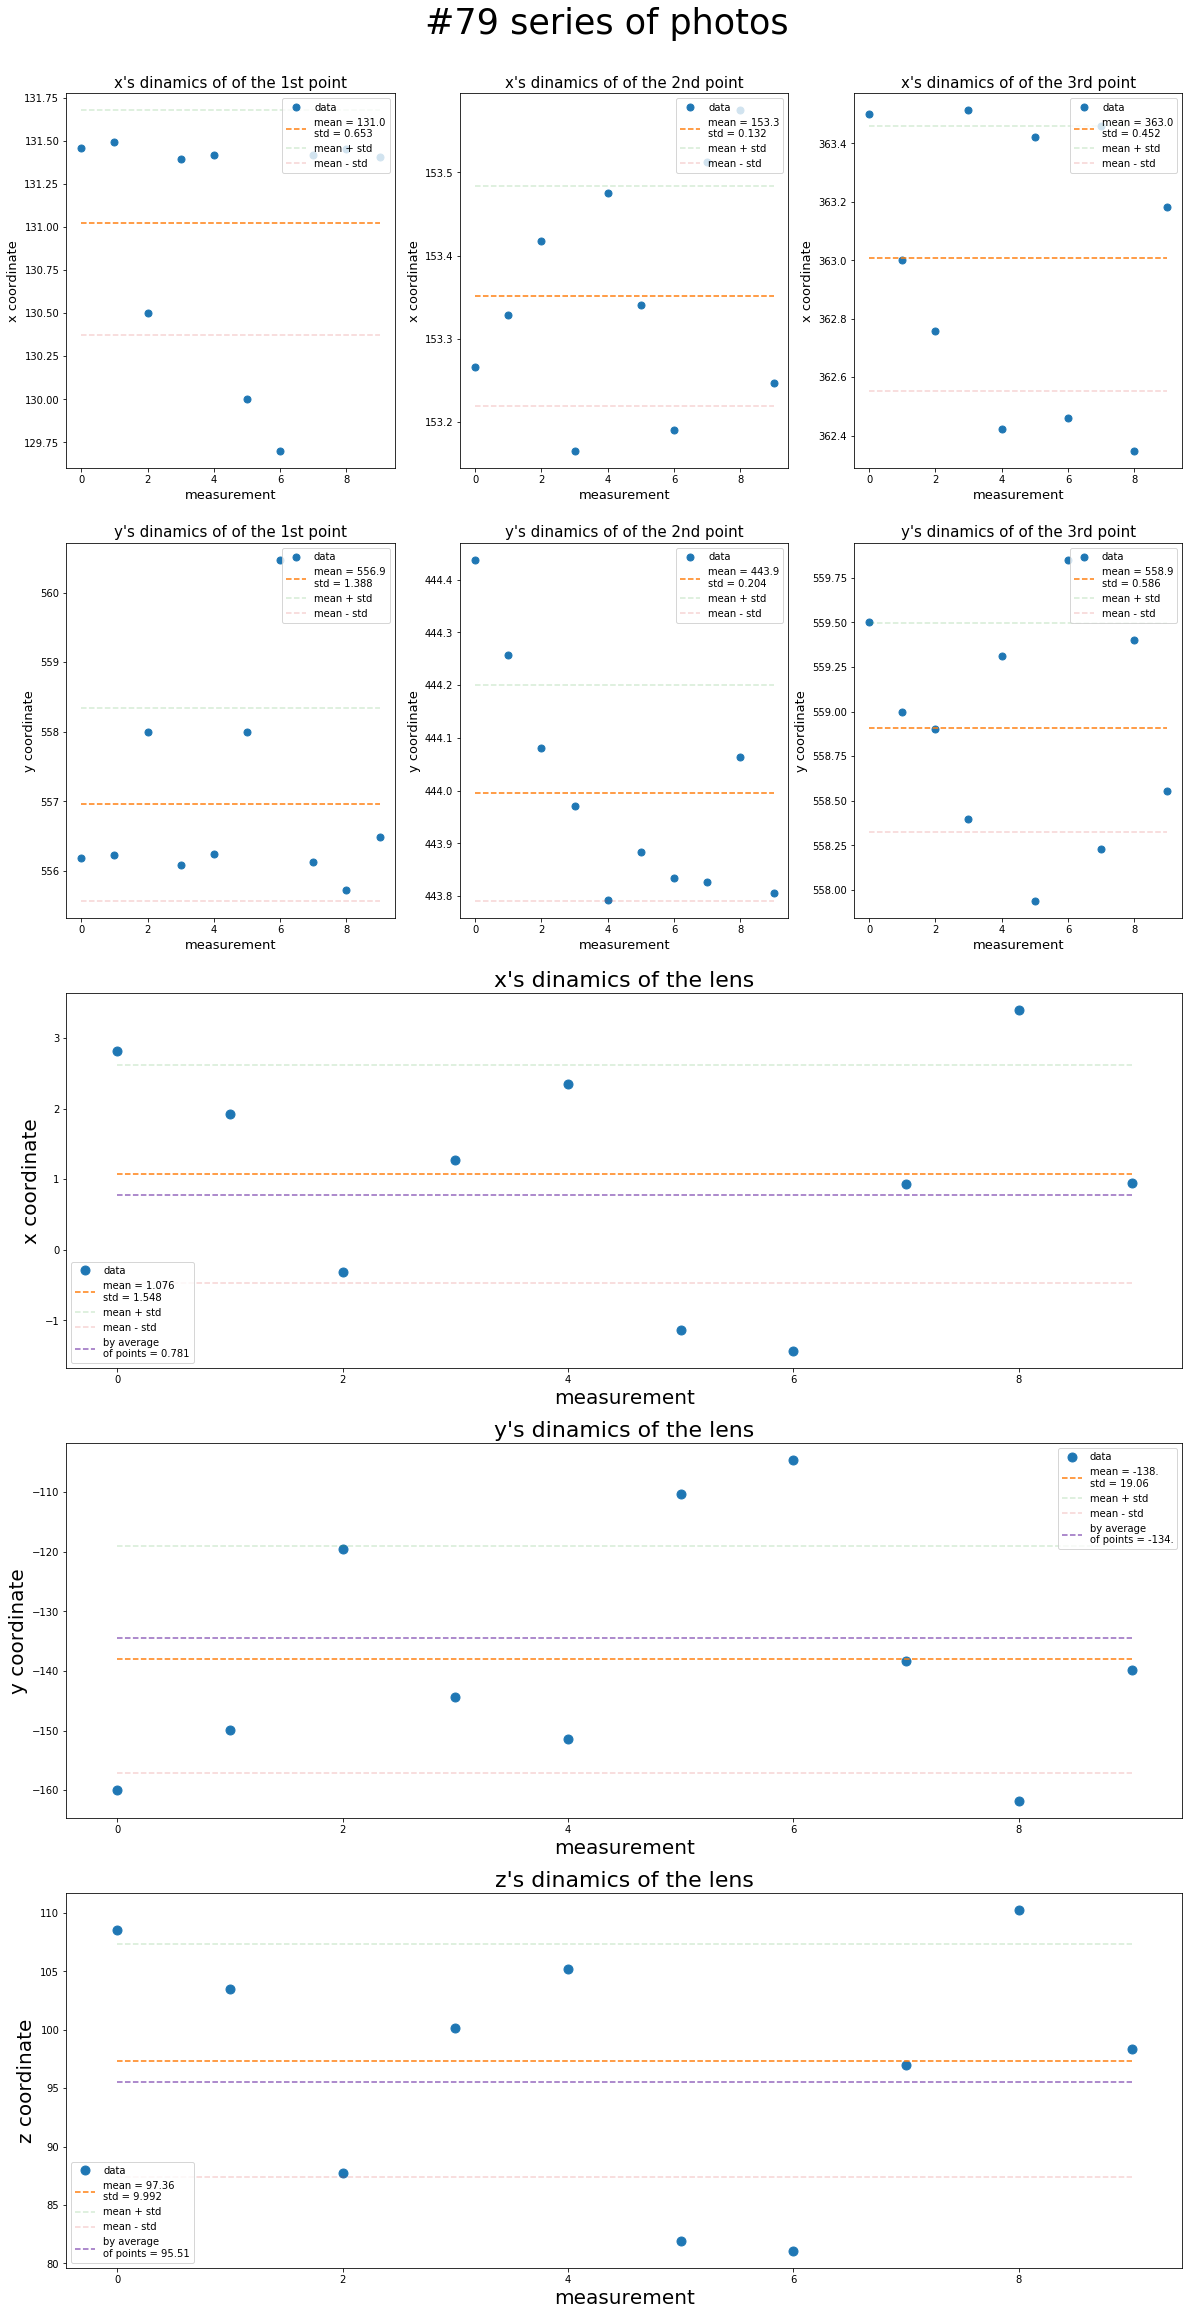

In [8]:
n = 79
plot_points(n)

In [9]:
def std_series (points):
    points = points.reshape(len(points)//3, 3, 2)
    std  = np.std(points, axis=0)
    
    return std
    
std_set = np.zeros((len(set), 3, 2))

for i in range(len(set)):
    std_set[i] = std_series(set[i]['points'])

In [10]:
a = set[79]['points'].reshape(10, 3, 2)
print (np.std(a[:, 0, 1]))

1.3887250316146416


In [11]:
print (std_set[79])

[[0.65300677 1.38872503]
 [0.13246097 0.20484414]
 [0.45225428 0.58618546]]


In [12]:
stdset = np.zeros((3, 2, len(std_set)))

stdset[0, 0] = std_set[:, 0, 0]
stdset[0, 1] = std_set[:, 0, 1]
stdset[1, 0] = std_set[:, 1, 0]
stdset[1, 1] = std_set[:, 1, 1]
stdset[2, 0] = std_set[:, 2, 0]
stdset[2, 1] = std_set[:, 2, 1]

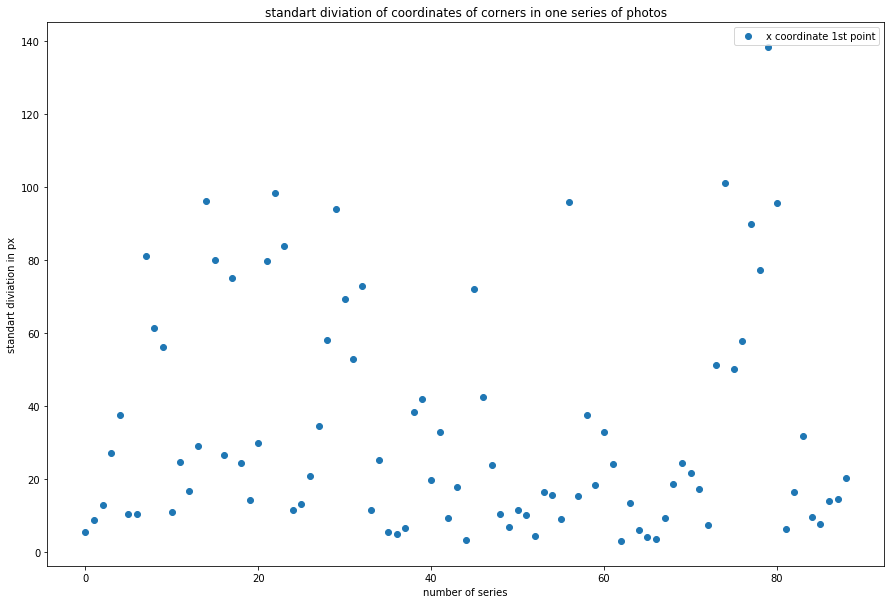

In [13]:
plt.figure(figsize=(15, 10))

sum_std = 100*stdset[0, 1] - 1*stdset[0, 0] * stdset[2, 1]+ 0*stdset[1, 0] + 0*stdset[1, 1] + 0*stdset[2, 0] 
plt.plot(sum_std, 'o', label='x coordinate 1st point')

plt.title ('standart diviation of coordinates of corners in one series of photos')
plt.xlabel('number of series')
plt.ylabel('standart diviation in px')

plt.legend(loc=0)

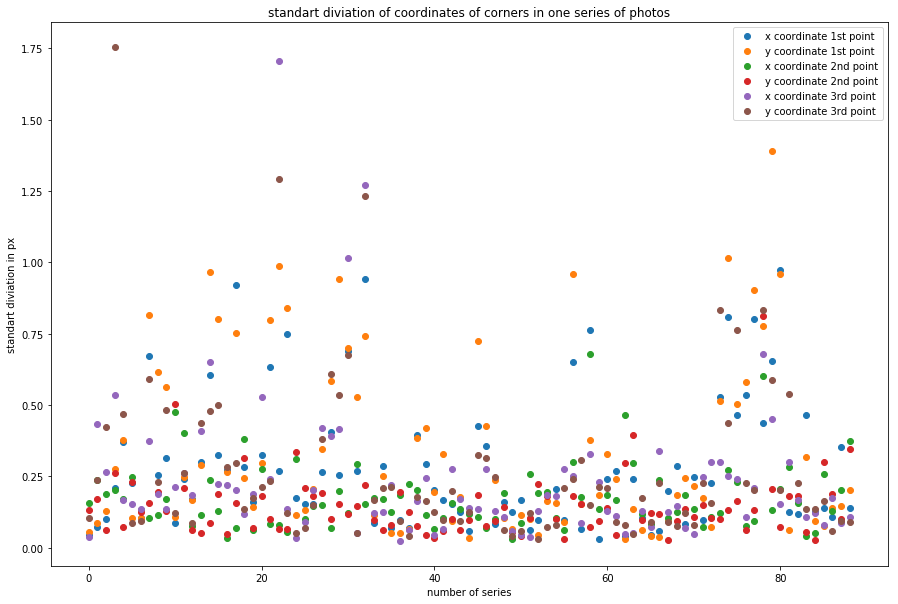

In [14]:
plt.figure(figsize=(15, 10))


plt.plot(stdset[0, 0], 'o', label='x coordinate 1st point')
plt.plot(stdset[0, 1], 'o', label='y coordinate 1st point')
plt.plot(stdset[1, 0], 'o', label='x coordinate 2nd point')
plt.plot(stdset[1, 1], 'o', label='y coordinate 2nd point')
plt.plot(stdset[2, 0], 'o', label='x coordinate 3rd point')
plt.plot(stdset[2, 1], 'o', label='y coordinate 3rd point')

plt.title ('standart diviation of coordinates of corners in one series of photos')
plt.xlabel('number of series')
plt.ylabel('standart diviation in px')

plt.legend(loc=0)

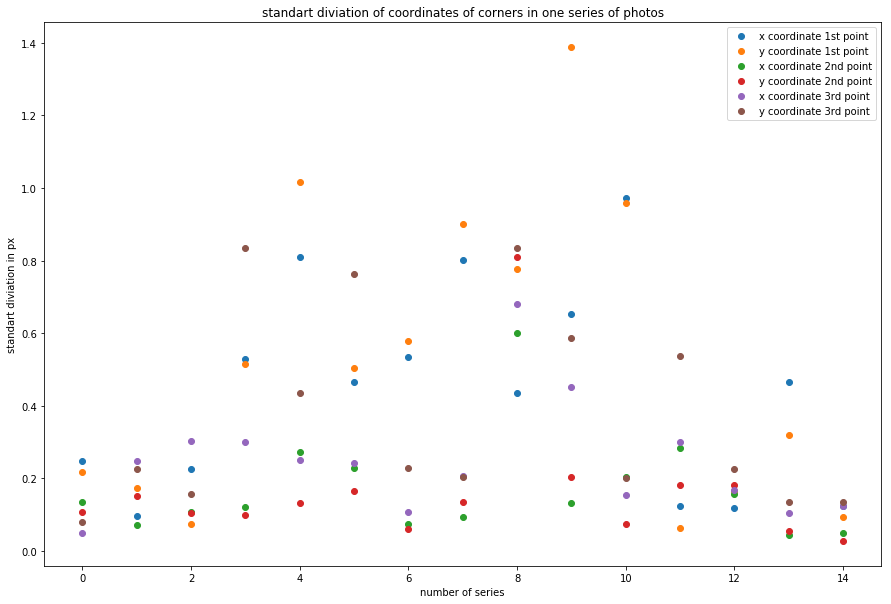

In [15]:
plt.figure(figsize=(15, 10))

n1 = 70
n2 = 85

plt.plot(stdset[0, 0][n1:n2], 'o', label='x coordinate 1st point')
plt.plot(stdset[0, 1][n1:n2], 'o', label='y coordinate 1st point')
plt.plot(stdset[1, 0][n1:n2], 'o', label='x coordinate 2nd point')
plt.plot(stdset[1, 1][n1:n2], 'o', label='y coordinate 2nd point')
plt.plot(stdset[2, 0][n1:n2], 'o', label='x coordinate 3rd point')
plt.plot(stdset[2, 1][n1:n2], 'o', label='y coordinate 3rd point')

plt.title ('standart diviation of coordinates of corners in one series of photos')
plt.xlabel('number of series')
plt.ylabel('standart diviation in px')

plt.legend(loc=0)

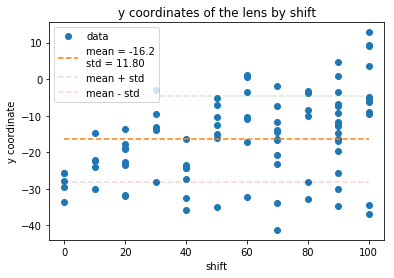

In [16]:
num = 2

shifts = np.zeros(len(set))
lenses  = np.zeros((len(set), 3))

for i in range(len(set)):
    shifts[i] += set[i]['shift']
    lenses[i]  += set[i]['lens_aver']
    
y = lenses[:, 1] + shifts
x = shifts

plot_data (x = x, y = y, markersize=None, fontsize=None, 
           title = 'y coordinates of the lens by shift', 
           xlabel = 'shift', ylabel = 'y coordinate', loc=0)




In [17]:
values = arr(list(dict.fromkeys(shifts)))
by_shift = {}

for i in range(len(set)):
    
    key = set[i]['shift']
    
    if (key not in by_shift):
        by_shift[key] = []
        
    buf = set[i].copy()
    buf.pop('shift')
    
    by_shift[key] += [buf]
print (by_shift[0][0]['name'])

__0_1559333601.8178179.jpg


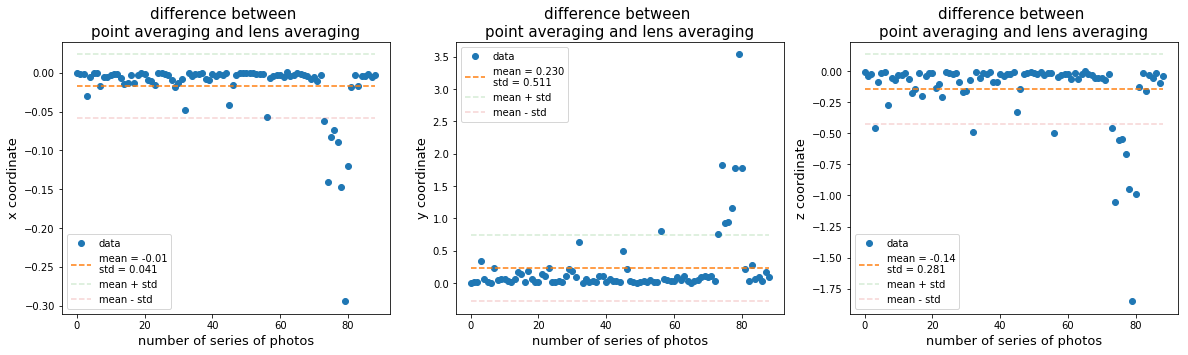

In [18]:
lens_aver = []
aver_lenses = []

for i in by_shift:
    for j in range(len(by_shift[i])):
        lens_aver   += [arr (by_shift[i][j]['lens_aver'])]
        aver_lenses += [arr (by_shift[i][j]['aver_lenses'])]
        
        
dif = arr(lens_aver) - arr(aver_lenses)


dim = ['x', 'y', 'z']
plt.figure (figsize = (20, 5))
for k in range(len(dim)):
    plt.subplot(int('13%i'%(k+1)))
    plot_data (dif.T[k][:], loc = 0, title = 'difference between \npoint averaging and lens averaging',
              xlabel = 'number of series of photos', ylabel = '%s coordinate' % (dim[k]),
              fontsize=13)

#74 - 81


In [19]:
print (dif[88])

[-0.00303766  0.10141372 -0.04134965]


In [20]:
a = {i: arr([j['lens_aver'] for j in by_shift[i]]) for i in by_shift}

for i in a:
    print (i)
    #print (a[i])
    #print ()

0
10
20
30
40
50
60
70
80
90
100


In [21]:
b = {j: [i['lenses'] for i in by_shift[j]] for j in by_shift} 

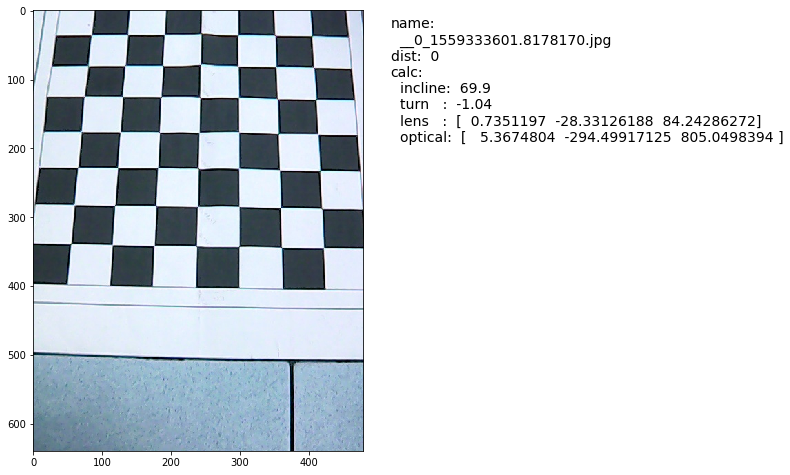

[  0.72047574 -27.98449024  83.53182972]
[  0.72064499 -27.98909498  83.53740939]
[-0.00016925  0.00460474 -0.00557967]

iteration:  0
Press fucking key: end


In [22]:

i = 0
while (1):
    
    clear_output()    
    
    k = 2.7
    plt.figure(figsize=(4*k, 3*k))
    
    image = cv2.imread(frames[i]['name'])
    data  = calibration_data(image, shape, size)
    
    text = text_data(frames[i], data)
    plt.gcf().text(0.76, 0.6, text, fontsize=14)
    
    plt.imshow(image)
    plt.show()
    
    
    print (lens_aver[i//10])
    print (aver_lenses[i//10])
    print (dif[i//10])
    print ()
    print ('iteration: ', i)
    
    key = input('Press fucking key: ')
    
    
    if (key == 'end'):
        break        
    elif (key == '-1'):
        i -= 1
    elif (key == '+10'):
        i += 10
    elif (key == '-10'):
        i -= 10
    elif (key == ''):
        i += 10
    else:
        i = int(key)

    if (i >= 889):
        i = 889

        

In [23]:
n1 = 720
n2 = 790

i = n1
'''
while ((i >= n1) and (i < n2)): 
    print ('iteration: ', i)
    plt.figure (figsize=(20, 8))
    
    for j in range(3):
            
        image = cv2.imread(frames[i]['name'])
        data  = calibration_data(image, shape, size)
        plt.subplot(int('13%i'%(j+1)))
        plt.imshow(image)
        plt.title(frames[i]['name'])
        i += 1
    i += 7
    plt.show()
'''

"\nwhile ((i >= n1) and (i < n2)): \n    print ('iteration: ', i)\n    plt.figure (figsize=(20, 8))\n    \n    for j in range(3):\n            \n        image = cv2.imread(frames[i]['name'])\n        data  = calibration_data(image, shape, size)\n        plt.subplot(int('13%i'%(j+1)))\n        plt.imshow(image)\n        plt.title(frames[i]['name'])\n        i += 1\n    i += 7\n    plt.show()\n"

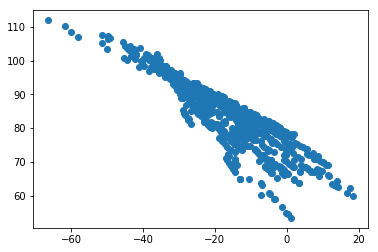

In [24]:
c = {j: arr([i['lens_aver'] for i in by_shift[j]]) for j in by_shift} 

y = arr([set[i]['lenses'][:, 1] + set[i]['shift'] for i in range(len(set))])
z = arr([set[i]['lenses'][:, 2] for i in range(len(set))])
a = arr([set[i]['incline'] for i in range(len(set))])

y = y.reshape(890)
z = z.reshape(890)

a = a.reshape(89)
inc = np.ones((89, 10))
for i in range(len(inc)):
    inc[i] *= a[i]

inc = inc.reshape(890)


plt.plot(y, z, 'o')

[-0.67641503 72.232295  ]


Text(0, 0.5, 'z coordinate')

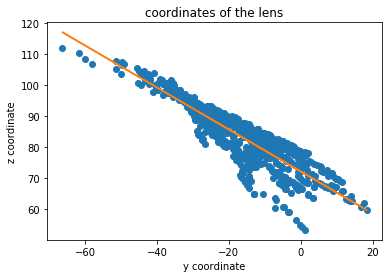

In [25]:
plt.plot(y, z, 'o')
k = np.polyfit(y, z, 1)
print (k)
plt.plot(y, k[0]*y+k[1])
plt.title ('coordinates of the lens')
plt.xlabel('y coordinate')
plt.ylabel('z coordinate')


In [26]:
def circle_lstsq(points):
    '''
    Gets points of spoiled circle 
    Returns radius, and coordinates of the center
    '''
    x = points.T[0]
    y = points.T[1]
    
    X2 = np.sum(x*x)
    Y2 = np.sum(y*y)
    X  = np.sum(x)
    Y  = np.sum(y)
    XY = np.sum(y*x)

    X3  = np.sum(x*x*x)
    Y3  = np.sum(y*y*y)
    XY2 = np.sum(x*y*y)
    X2Y = np.sum(x*x*y)

    N11 = 2 * (X2 - 1/n * X**2)
    N12 = 2 * (XY - 1/n * X*Y)
    N21 = 2 * (XY - 1/n * X*Y)
    N22 = 2 * (Y2 - 1/n * Y**2)

    W1 = X3 + XY2 - 1/n * X * (X2 + Y2)
    W2 = Y3 + X2Y - 1/n * Y * (X2 + Y2)

    N = arr([[N11, N12], [N21, N22]])
    W = arr([W1, W2])

    C = np.linalg.solve(N, W)
    R2 = C[0]**2 + C[1]**2 + 1/n * (X2 + Y2 - 2 * (C[0] * X + C[1] * Y))
    R = np.sqrt(R2)
    
    return C, R

def circle(c, r, n=100, ang1=0, ang2=2*np.pi):
    '''
    Gets coordinates of circle, radius and number of points
    Return set of points
    '''
    a = np.linspace(ang1, ang2, n)
    points = c * np.ones([n, 2]) + r * arr([cos(a), sin(a)]).transpose()
    
    return points 

def plt_circle(points, marker=None, label=None):
    plt.plot(points.T[0], points.T[1], marker=marker, label=label)

Text(0, 0.5, 'z coordinate')

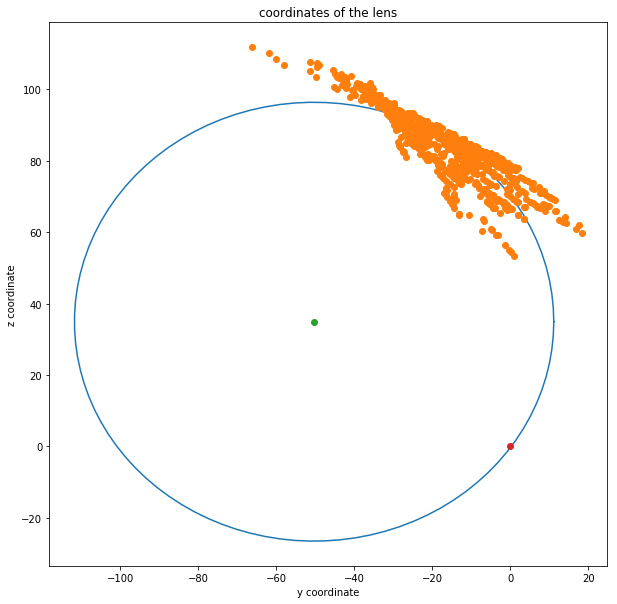

In [27]:
points = arr([y, z]).T
C, R = circle_lstsq(points)

plt.figure(figsize=(10, 10))
cir = circle(C, R)
plt_circle(cir)
plt.plot (points.T[0], points.T[1], 'o')
plt.plot (C[0], C[1], 'o')
plt.plot (0, 0, 'o')
plt.title ('coordinates of the lens')
plt.xlabel('y coordinate')
plt.ylabel('z coordinate')



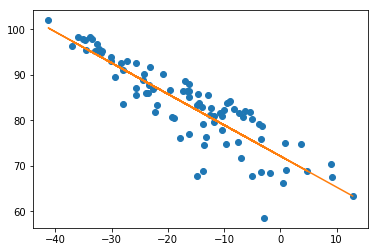

In [28]:
c = {j: arr([i['lens_aver'] for i in by_shift[j]]) for j in by_shift} 
lenses = arr([set[i]['lens_aver'] for i in range(len(set))])
shifts = arr([set[i]['shift'] for i in range(len(set))])
y1 = lenses[:, 1] + shifts
z1 = lenses[:, 2]

plt.plot(y1, z1, 'o')
k = np.polyfit(y1, z1, 1)
plt.plot(y1, k[0]*y1+k[1])

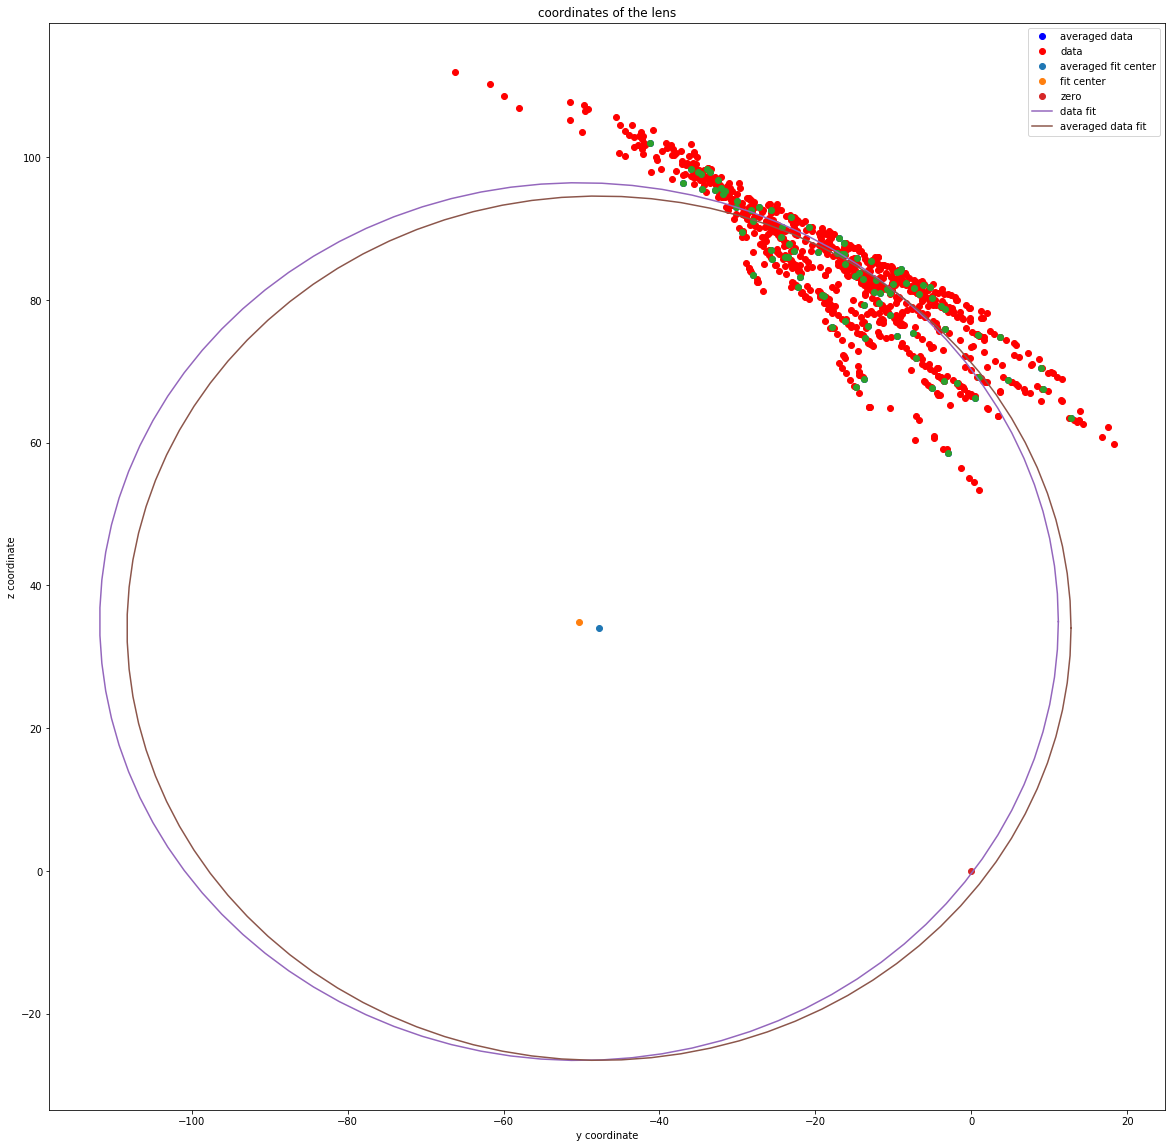

[-47.7498408   34.00905779] 60.5426080021376


In [29]:
plt.figure(figsize=(20, 20))




plt.plot(y1, z1, 'o', color='b', label='averaged data')
plt.plot(y, z, 'o', color='r', label='data')
points = arr([y1, z1]).T

C1, R1 = circle_lstsq(points)
cir1   = circle(C1, R1)


plt.plot(C1[0], C1[1], 'o', label='averaged fit center')
plt.plot (C[0], C[1], 'o', label='fit center')

cir = circle(C, R)
plt.plot (points.T[0], points.T[1], 'o')


plt.plot(0, 0, 'o', label='zero')

plt_circle(cir, label='data fit')
plt_circle(cir1, label='averaged data fit')

plt.title ('coordinates of the lens')
plt.xlabel('y coordinate')
plt.ylabel('z coordinate')

plt.legend()
plt.show()
print (C1, R1)

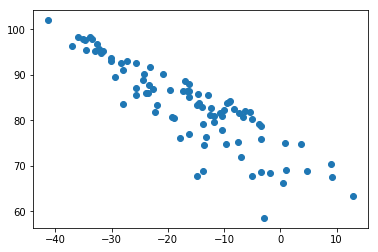

In [30]:
import circle_fit as cf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles

x, y = y1, z1
plt.scatter(x, y)

-251.78274003248762 -230.6286246791086 393.3340755827063


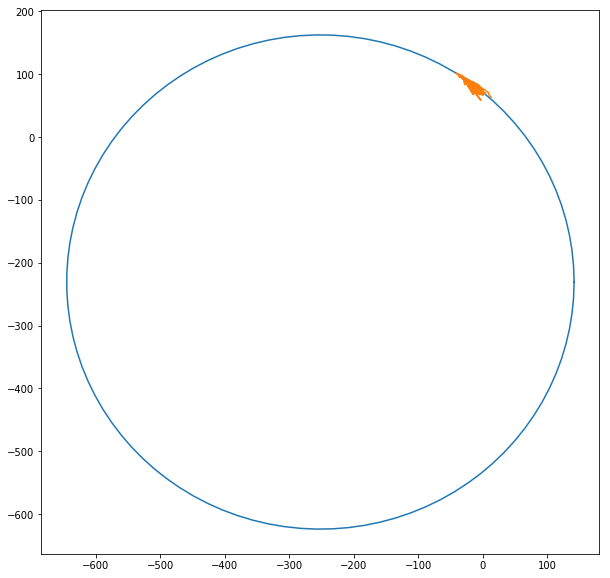

In [31]:
coords = arr([y1, z1]).T

xc,yc,r,s = cf.hyper_fit(coords)

plt.figure(figsize=(10, 10))

print (xc, yc, r)
cir2 = circle(arr([xc, yc]), r)
plt_circle(cir2)
plt_circle(coords)

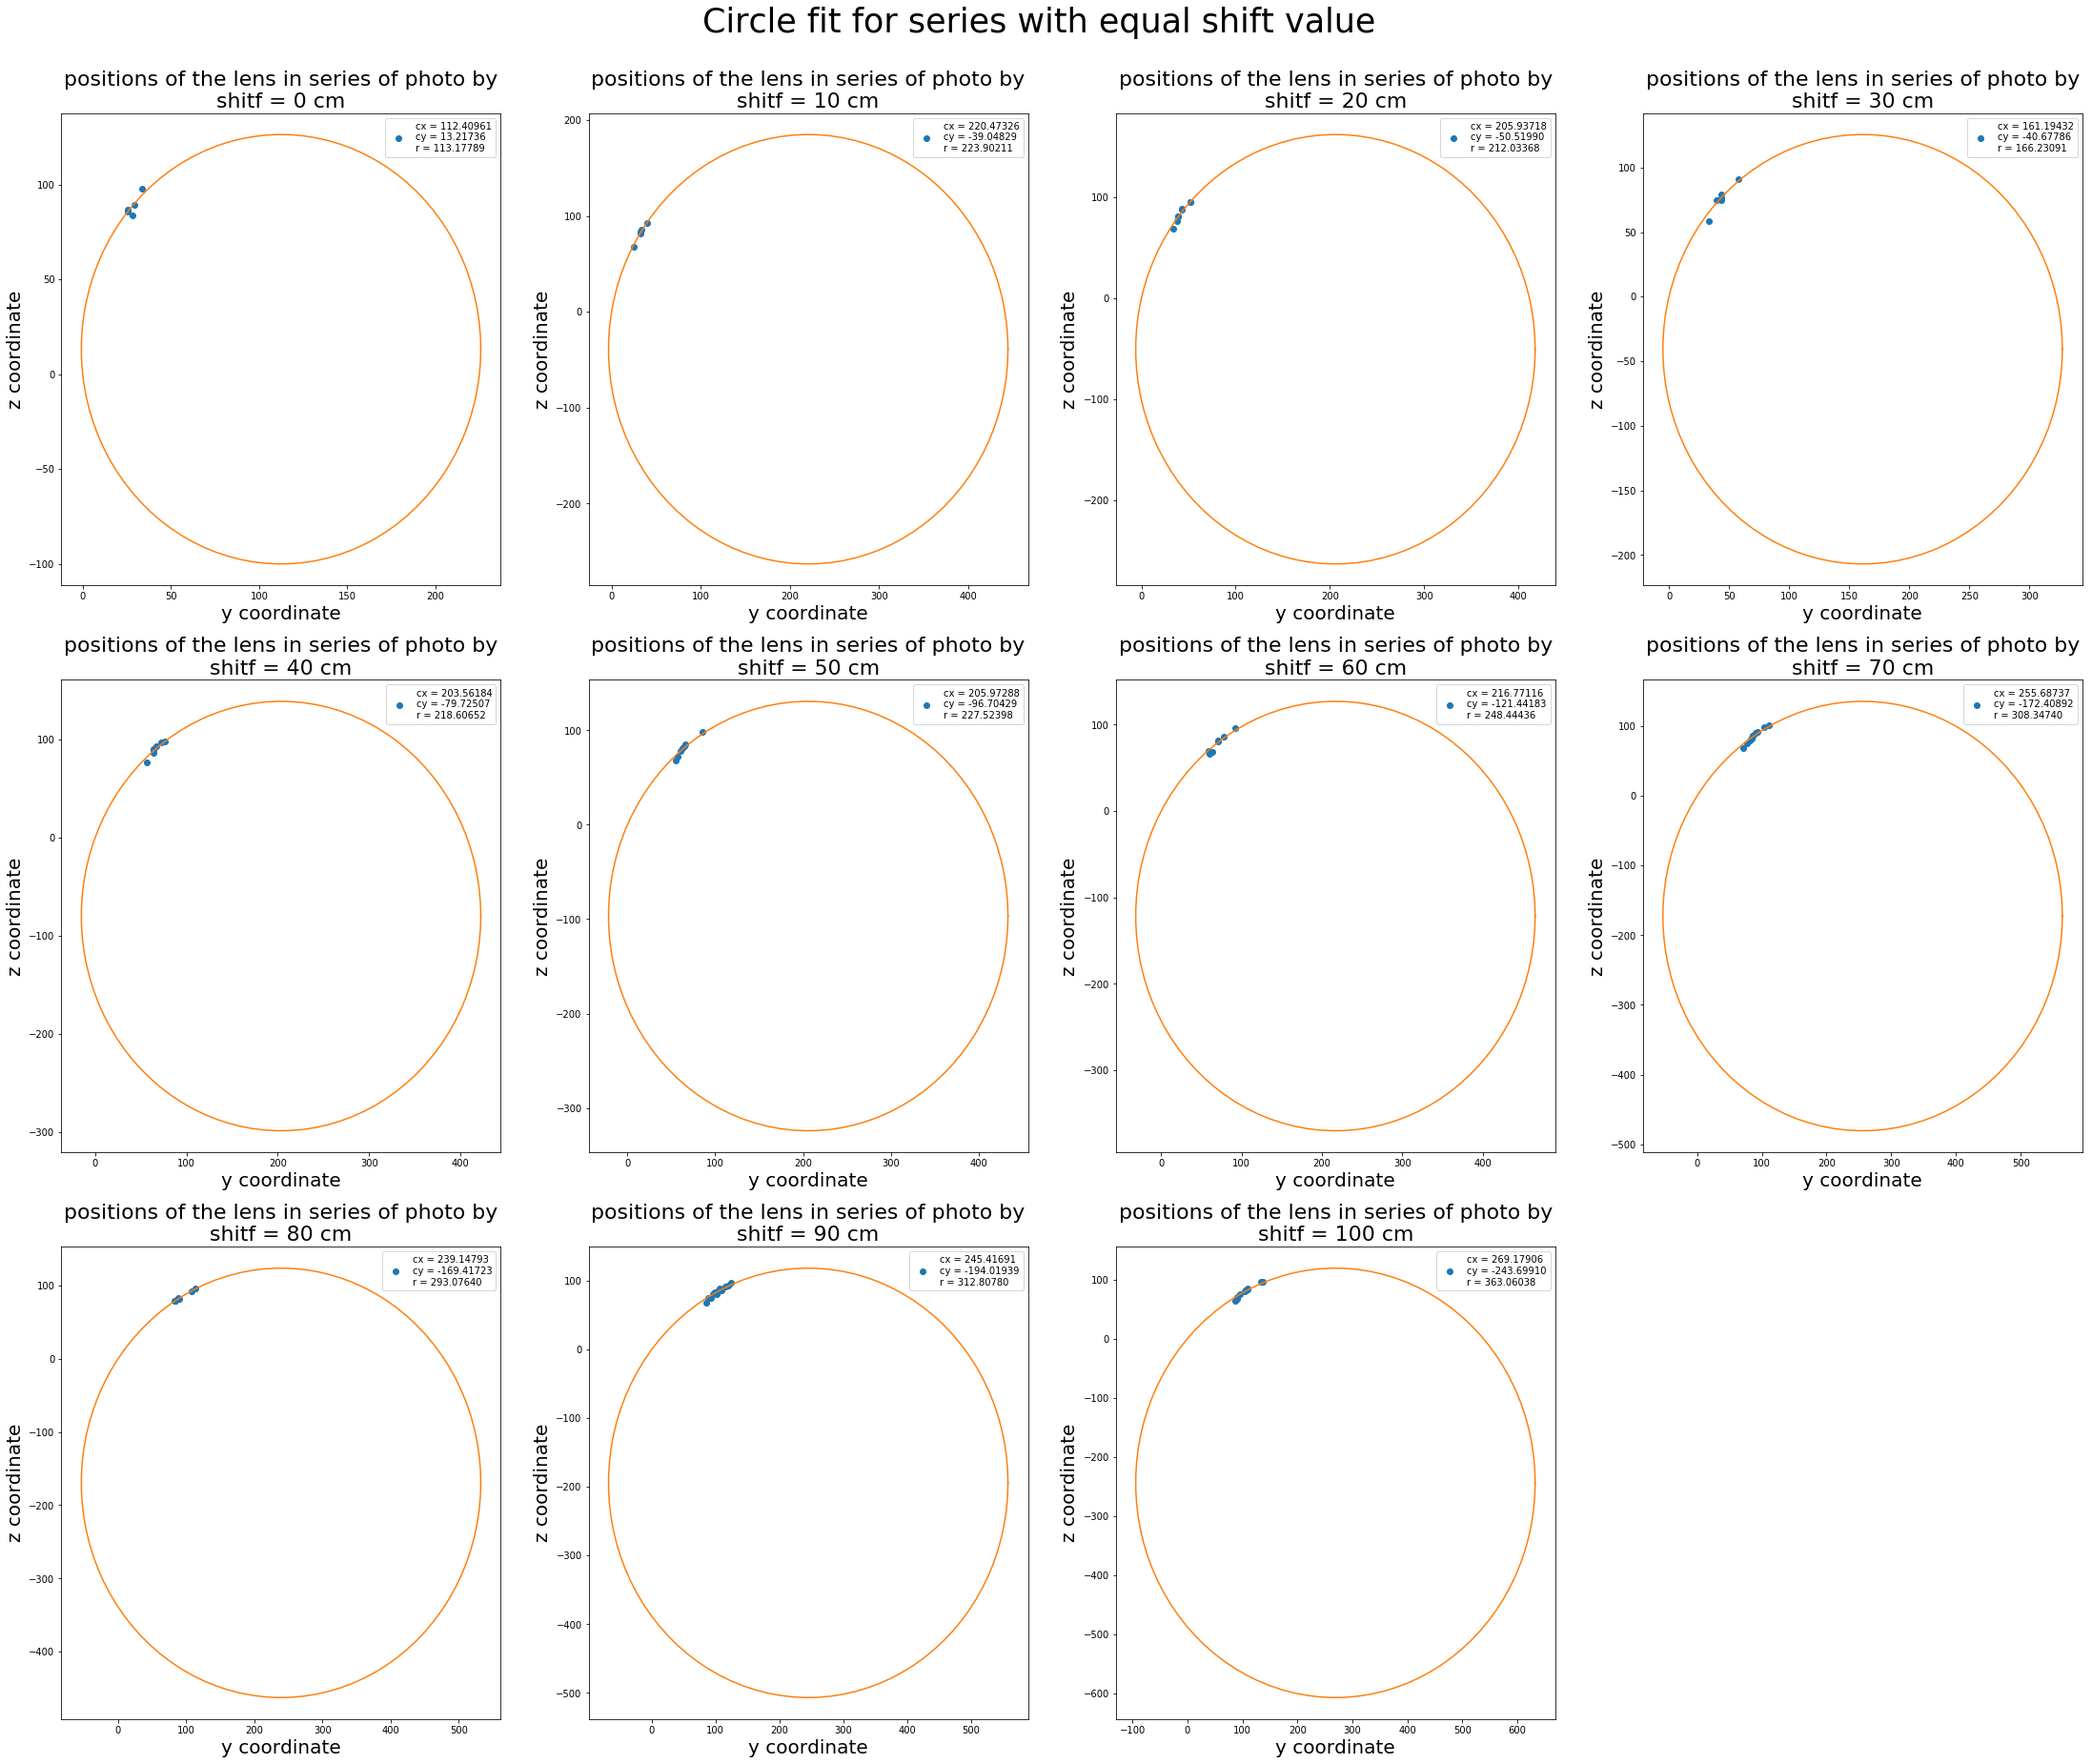

In [32]:
lenses = {j: arr([i['lens_aver'] for i in by_shift[j]]) for j in by_shift} 
angles = {j: arr([i['incline']   for i in by_shift[j]]) for j in by_shift} 

cents = np.zeros((len(lenses), 2))
rs    = np.zeros(len(lenses))

plt.figure(figsize=(38, 31))
plt.suptitle ('Circle fit for series with equal shift value', y=0.93, fontsize=35)
for i in range(len(lenses)):
       
    ind = 10*i
    y = -lenses[ind][:, 1] - 0*ind * np.ones(len(lenses[ind]))
    z = lenses[ind][:, 2]

    coords = arr([y, z]).T

    #xc,yc,r,s = cf.hyper_fit(coords)
    C, R = circle_lstsq(coords)
    cents[ind//10], rs[ind//10] = C, R

    #print ('ind: ', ind)
    #print ('C: %.5f %.5f\nR: %.5f' % (xc, yc, r))
    #print ('C: %.5f %.5f\nR: %.5f' % (C[0], C[1], R))
    #cir2 = circle(arr([xc, yc]), r)
    cir2 = circle(C, R)
    
    plt.subplot(3, 4, i+1)
    plt.plot (y, z, 'o', label='cx = %.5f\ncy = %.5f\nr = %.5f'%(C[0], C[1], R))
    plt_circle (cir2)
    plt.title('positions of the lens in series of photo by\nshitf = %i cm' % ind, fontsize=22)
    plt.xlabel ('y coordinate', fontsize=20)
    plt.ylabel ('z coordinate', fontsize=20)
    plt.legend ()

plt.show()

0
[-27.98449024 -29.40062695 -25.61307644 -25.68226488 -33.50809437]


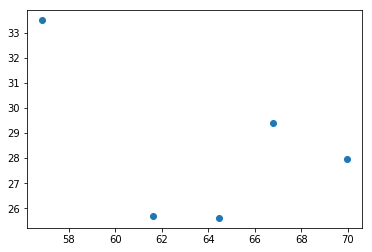

10
[-24.85010391 -32.27792364 -31.98282022 -33.94440285 -40.13037928]


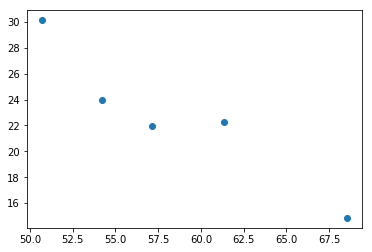

20
[-33.74928366 -37.82505377 -38.88104421 -39.18087477 -42.68539026
 -43.35913281 -51.61450689 -51.88761554]


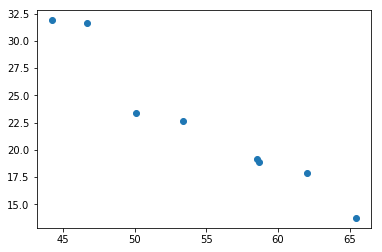

30
[-32.95818754 -43.6177779  -43.19468313 -39.59205226 -43.7966049
 -58.01720186]


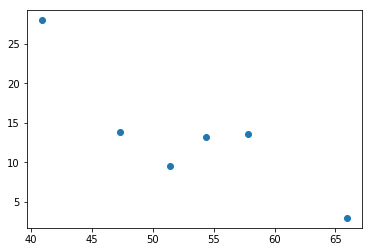

40
[-56.25546991 -63.54720317 -64.36469311 -64.22228169 -67.23910183
 -72.51421706 -75.92576248]


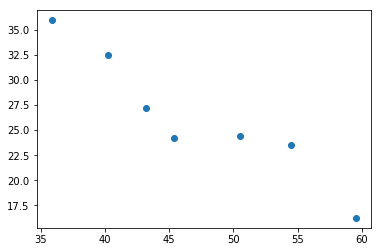

50
[-85.1021902  -66.15834337 -64.87008749 -62.49309511 -60.3741595
 -57.06207628 -55.09580941]


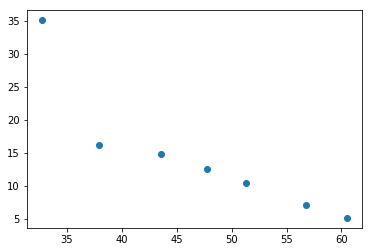

60
[-92.16532515 -77.28408231 -70.81580885 -70.43335234 -58.95994635
 -59.52820316 -63.45266826]


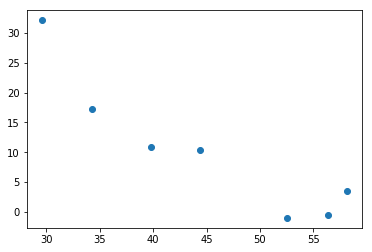

70
[-111.24314594 -103.87458856  -90.85044395  -93.16826221  -86.54873103
  -86.29591701  -84.42435616  -83.87855502  -81.82489454  -77.44759944
  -71.87115426]


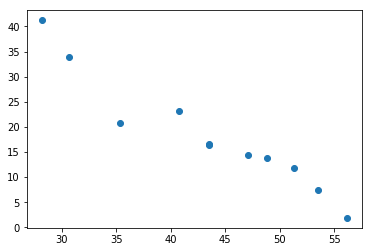

80
[-112.87559475 -108.25287224  -88.31754317  -83.84881941  -83.35683476
  -90.01784854]


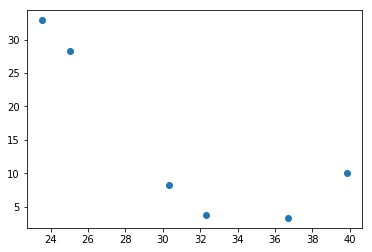

90
[ -85.31932333 -101.71654406  -96.71431798  -89.17157941  -93.37693667
 -102.28561198 -104.68986423  -97.323669   -106.2702711  -107.02450952
  -99.20000784 -102.92258681 -115.72687983 -124.72116775 -120.05161784
 -109.65558084]


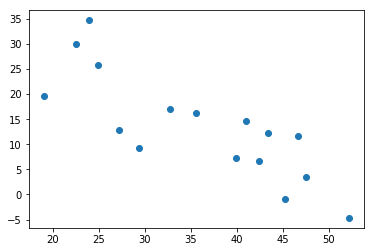

100
[-137.01525958 -134.48515972 -109.01054316 -106.2250918  -109.55025706
 -105.32496364 -105.01292531  -96.35341392  -91.02885735  -90.76845753
  -87.16092757]


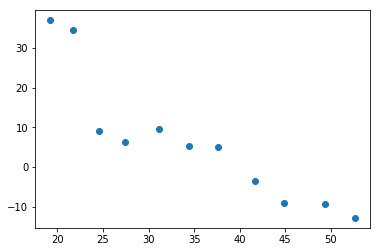

In [33]:
for i in lenses:
    print (i)
    plt.plot (angles[i], -lenses[i][:, 1] - i*np.ones(len (lenses[i][:, 1])), 'o')
    print (lenses[i][:, 1])
    plt.show ()

In [34]:
def polinom (x, k):
    x = arr(x)
    y = np.zeros (len (x))
    
    for i in range (len (k)):
        y += k[i] * x**(len(k)-1-i)
    
    return y

Text(0, 0.5, 'value in cm')

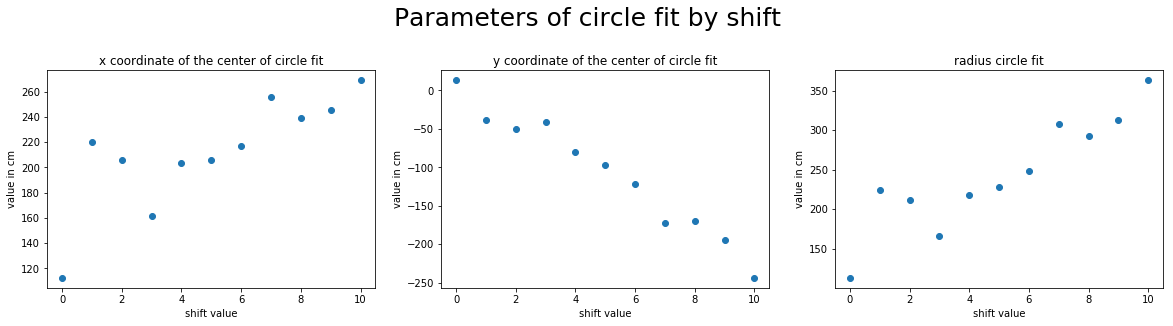

In [35]:
plt.figure (figsize=(20, 4))
plt.suptitle ('Parameters of circle fit by shift', y=1.1, fontsize=25)

plt.subplot(1, 3, 1)
plt.plot (cents[:, 0], 'o')
plt.title ('x coordinate of the center of circle fit')
plt.xlabel ('shift value')
plt.ylabel ('value in cm')

plt.subplot(1, 3, 2)
plt.plot (cents[:, 1], 'o')
plt.title ('y coordinate of the center of circle fit')
plt.xlabel ('shift value')
plt.ylabel ('value in cm')

plt.subplot(1, 3, 3)
plt.plot (rs, 'o')
plt.title ('radius circle fit')
plt.xlabel ('shift value')
plt.ylabel ('value in cm')



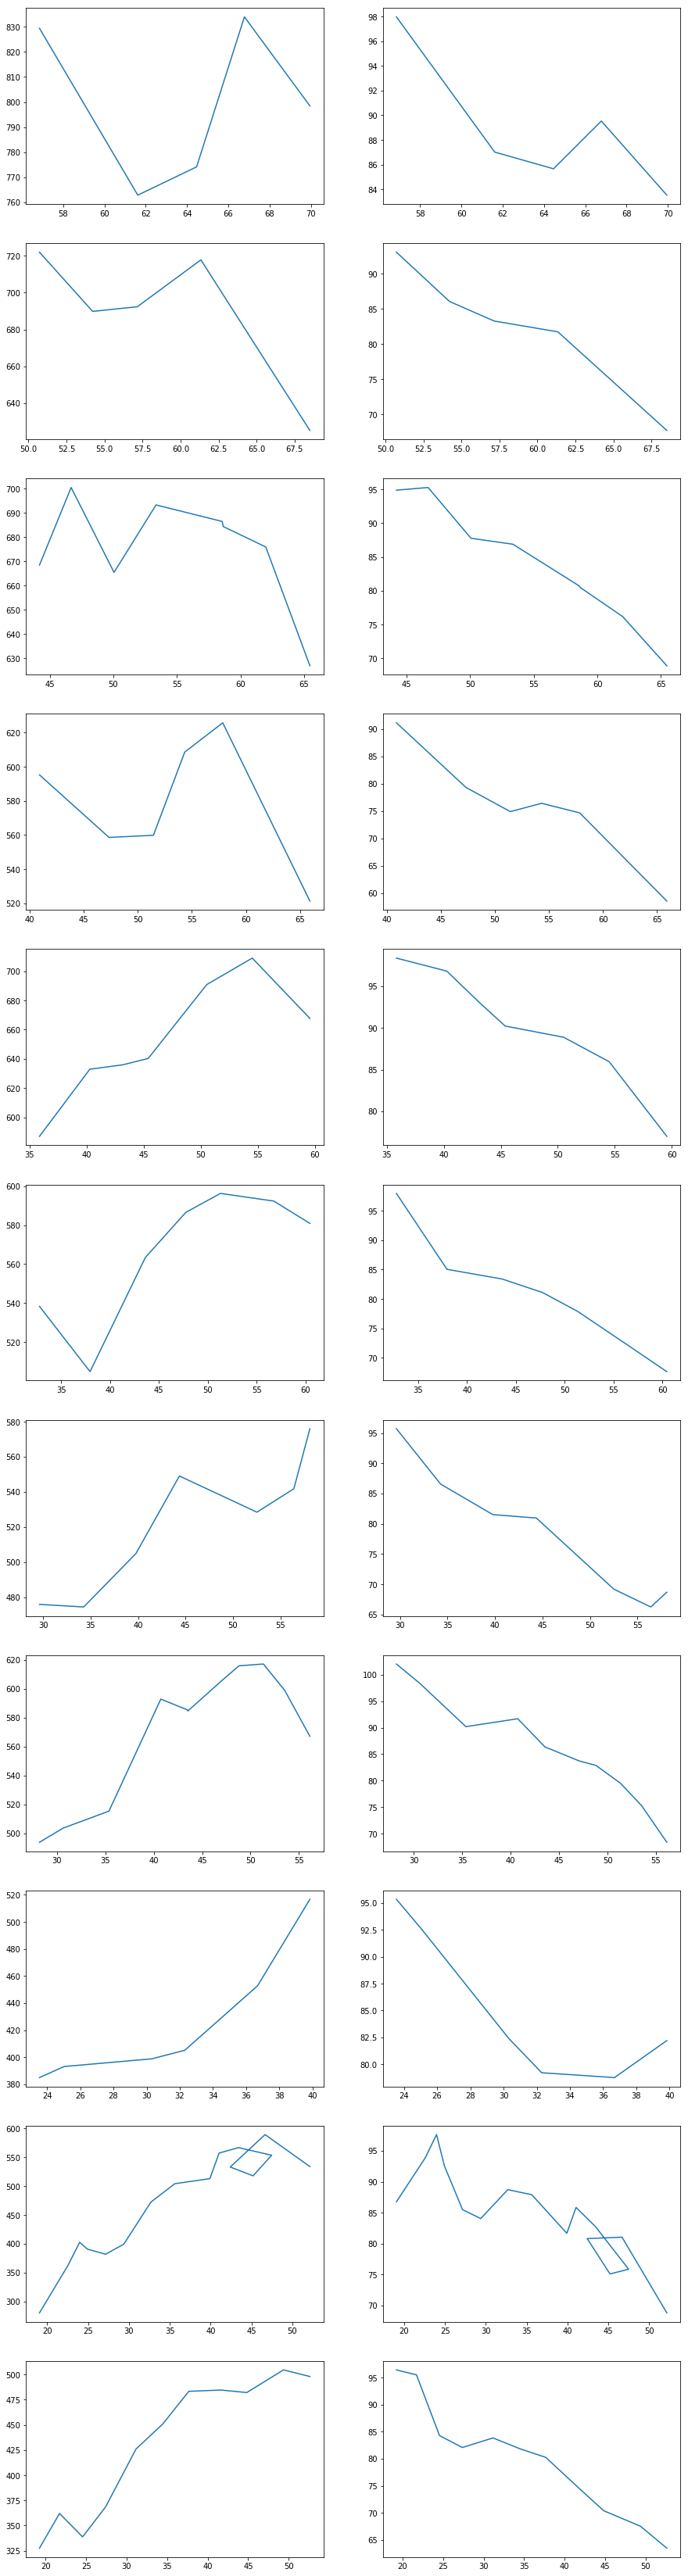

In [82]:
lenses = arr([set[i]['lens_aver'] for i in range(len(set))])
shifts = arr([set[i]['shift'] for i in range(len(set))])

lenses = {i: arr([j['lens_aver'] for j in by_shift[i]]) for i in by_shift}
angles = {i: arr([j['incline'] for j in by_shift[i]]) for i in by_shift}
fs     = {i: arr([j['f_aver']  for j in by_shift[i]]) for i in by_shift}
lens   = {i: arr([j['opt_len'] for j in by_shift[i]]) for i in by_shift}

i = 0

'''
print (angles[i])
print (fs[i])
print (lens[i])
'''

plt.figure (figsize=(15, 60))
for i in fs:
    plt.subplot (len(fs), 2, 2*i//10+1)
    plt.plot(angles[i], fs[i][:, 0][:, 2])
    plt.subplot (len(fs), 2, 2*i//10+2)
    plt.plot(angles[i], lenses[i][:, 2])


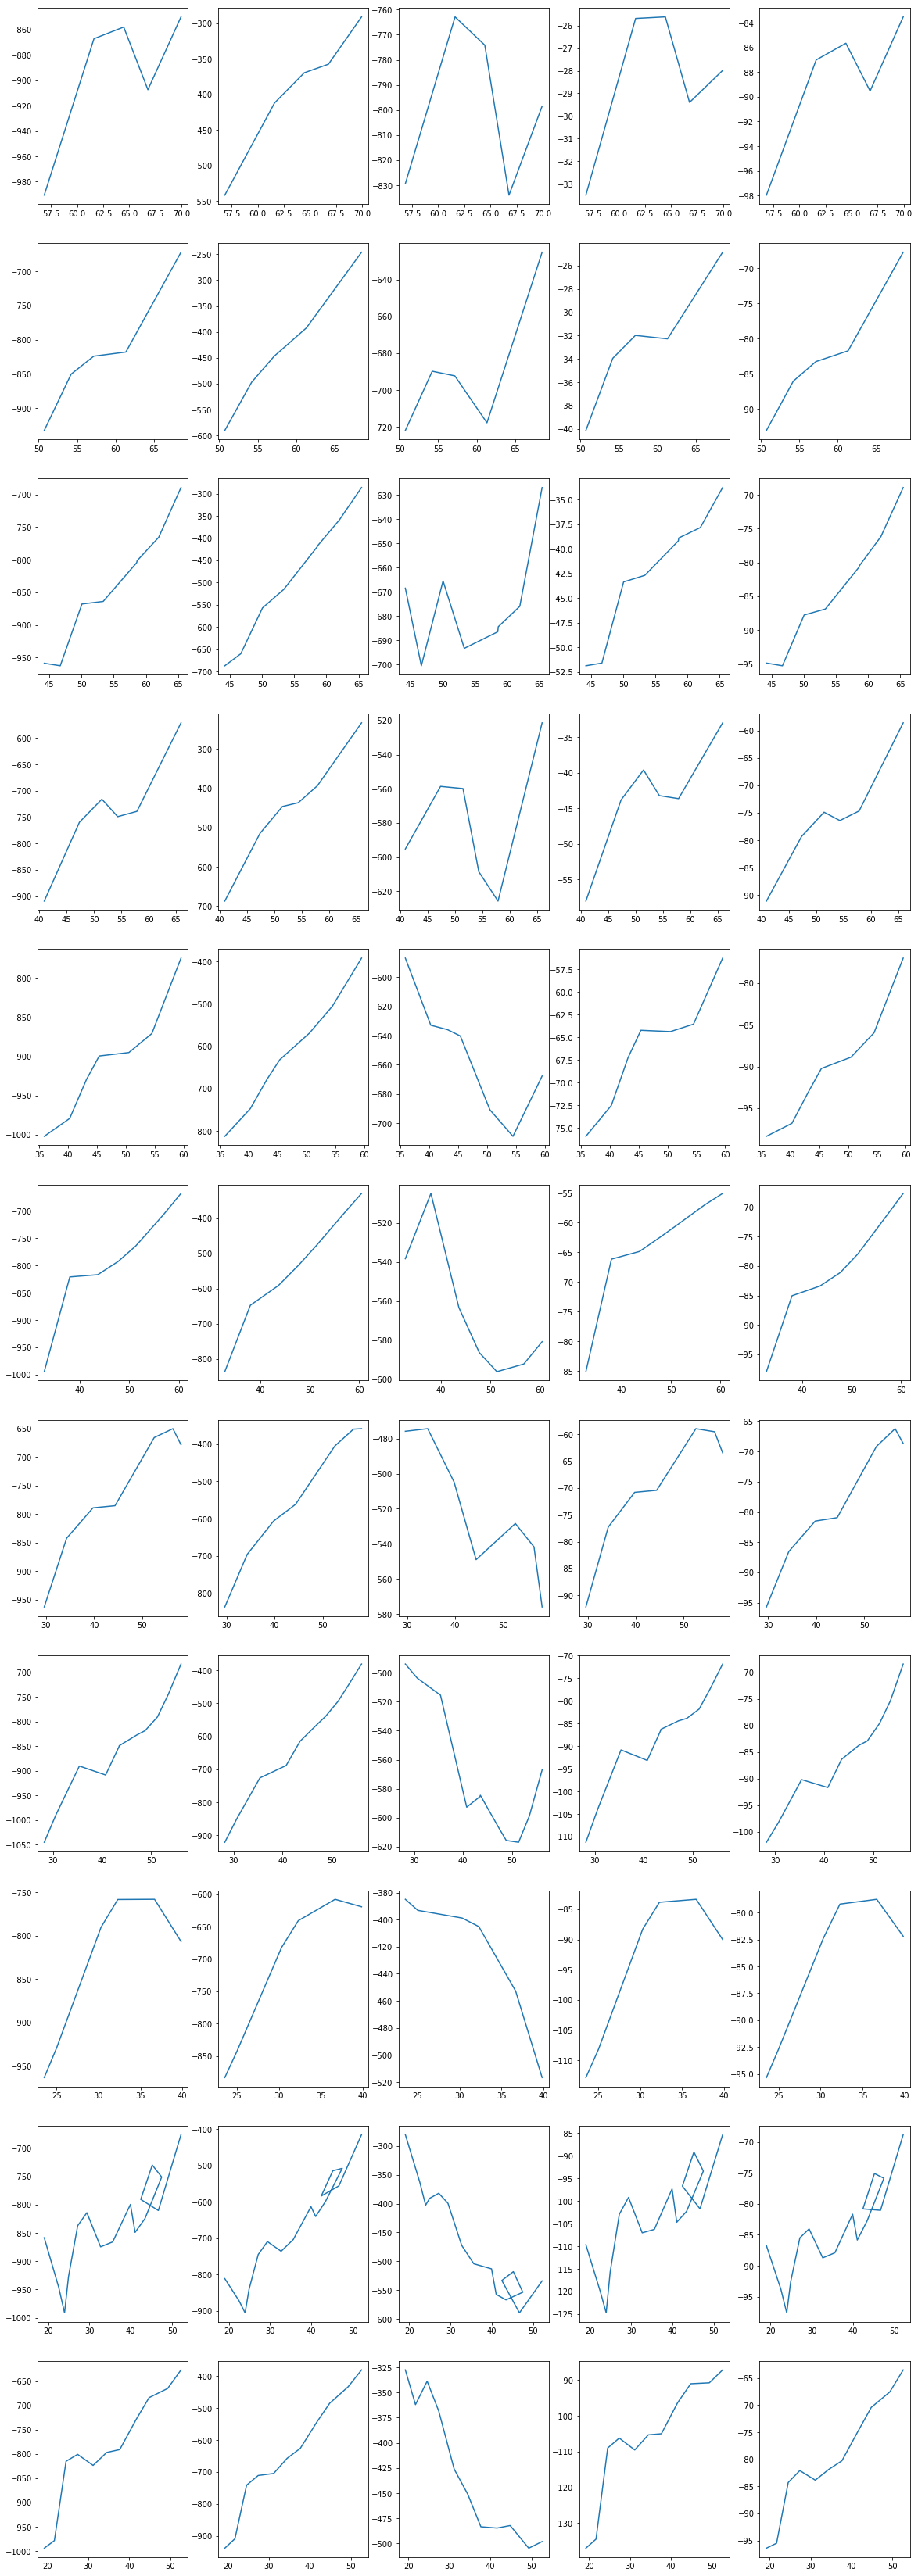

In [90]:
lenses = arr([set[i]['lens_aver'] for i in range(len(set))])
shifts = arr([set[i]['shift'] for i in range(len(set))])

lenses = {i: arr([j['lens_aver'] for j in by_shift[i]]) for i in by_shift}
angles = {i: arr([j['incline'] for j in by_shift[i]]) for i in by_shift}
fs     = {i: arr([j['f_aver']  for j in by_shift[i]]) for i in by_shift}
lens   = {i: arr([j['opt_len'] for j in by_shift[i]]) for i in by_shift}

i = 0

'''
print (angles[i])
print (fs[i])
print (lens[i])
'''
n = 5

plt.figure (figsize=(20, 60))
for i in fs:
    
    plt.subplot (len(fs), n, n*i//10+1)
    plt.plot(angles[i], -lens[i])
    
    plt.subplot (len(fs), n, n*i//10+2)
    plt.plot(angles[i], fs[i][:, 0][:, 1])
    
    plt.subplot (len(fs), n, n*i//10+3)
    plt.plot(angles[i], -fs[i][:, 0][:, 2])
    
    plt.subplot (len(fs), n, n*i//10+4)
    plt.plot(angles[i], lenses[i][:, 1])
    
    plt.subplot (len(fs), n, n*i//10+5)
    plt.plot(angles[i], -lenses[i][:, 2])
